In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 导入数据
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")
# 提取出图像信息，并将内容从0~255的整数转换为0.0~1.0的浮点数
# 图像大小为28*28，数组中每一行代表一张图像
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

训练集大小：60000
测试集大小：10000


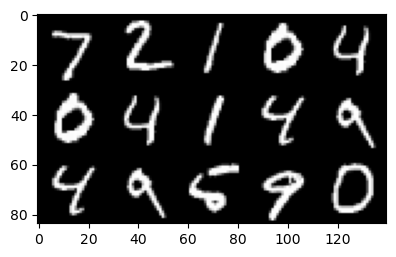

In [2]:
def display(data, m, n):
    # data：图像的像素数据，每行代表一张图像
    # m，n：按m行n列的方式展示前m * n张图像
    img = np.zeros((28 * m, 28 * n))
    for i in range(m):
        for j in range(n):
            # 填充第i行j列图像的数据
            img[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = data[i * m + j].reshape(28, 28)
    plt.figure(figsize=(m * 1.5, n * 1.5))
    plt.imshow(img, cmap='gray')
    plt.show()

display(x_test, 3, 5)

In [3]:
# 多层感知机
class MLP(nn.Module):

    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList() # ModuleList用列表存储PyTorch模块
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1:]:
            # 创建全连接层
            self.layers.append(nn.Linear(num_in, num_out))
            # 创建逻辑斯谛激活函数层
            self.layers.append(nn.Sigmoid())
            num_in = num_out

    def forward(self, x):
        # 前向传播
        for l in self.layers:
            x = l(x)
        return x

layer_sizes = [784, 256, 128, 100]
encoder = MLP(layer_sizes)
decoder = MLP(layer_sizes[::-1]) # 解码器的各层大小与编码器相反

训练轮数：0，平均损失：0.0311


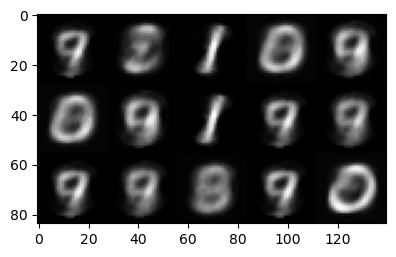

训练轮数：2，平均损失：0.0190


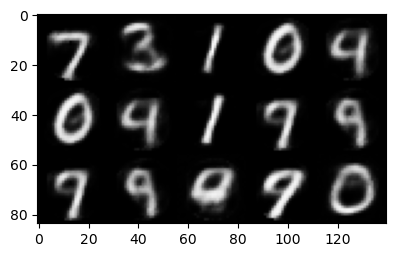

训练轮数：4，平均损失：0.0118


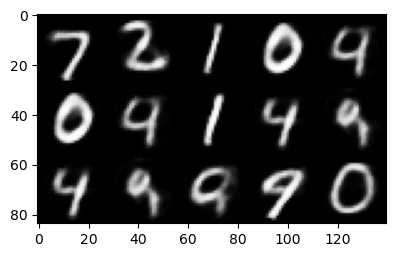

训练轮数：6，平均损失：0.0091


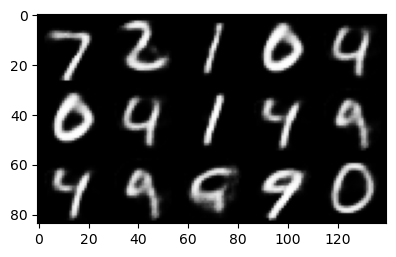

训练轮数：8，平均损失：0.0073


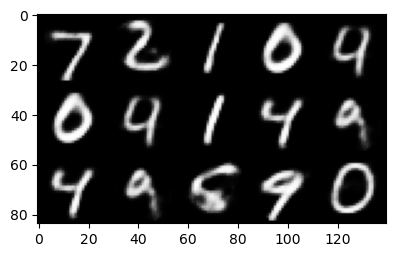

训练轮数：9，平均损失：0.0067


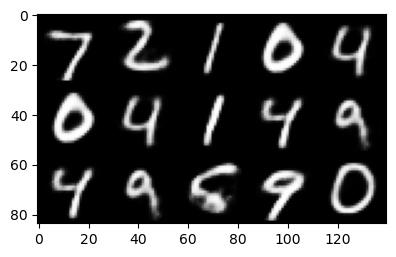

In [4]:
# 训练超参数
learning_rate = 0.01 # 学习率
max_epoch = 10 # 训练轮数
batch_size = 256 # 批量大小
display_step = 2 # 展示间隔
np.random.seed(0)
torch.manual_seed(0)

# 采用Adam优化器，编码器和解码器的参数共同优化
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
# 开始训练
for i in range(max_epoch):
    # 打乱训练样本
    idx = np.arange(len(x_train))
    idx = np.random.permutation(idx)
    x_train = x_train[idx]
    st = 0
    ave_loss = [] # 记录每一轮的平均损失
    while st < len(x_train):
        # 遍历数据集
        ed = min(st + batch_size, len(x_train))
        X = torch.from_numpy(x_train[st: ed]).to(torch.float32)
        Z = encoder(X)
        X_rec = decoder(Z)
        loss = 0.5 * nn.functional.mse_loss(X, X_rec) # 重建损失
        ave_loss.append(loss.item())
        optimizer.zero_grad() 
        loss.backward() # 梯度反向传播
        optimizer.step()
        st = ed
    ave_loss = np.average(ave_loss)

    if i % display_step == 0 or i == max_epoch - 1:
        print(f'训练轮数：{i}，平均损失：{ave_loss:.4f}')
        # 选取测试集中的部分图像重建并展示
        with torch.inference_mode():
            X_test = torch.from_numpy(x_test[:3 * 5]).to(torch.float32)
            X_test_rec = decoder(encoder(X_test))
            X_test_rec = X_test_rec.cpu().numpy()
        display(X_test_rec, 3, 5)

原始图像


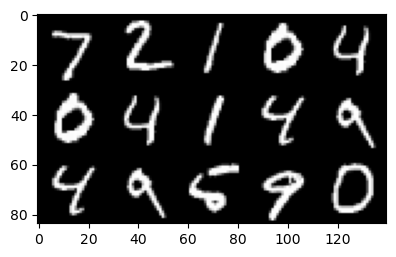

重建图像


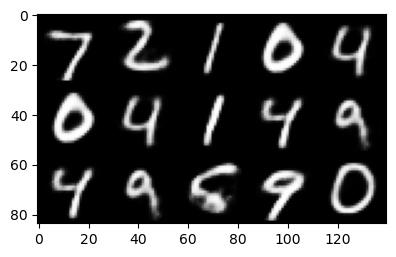

In [5]:
print('原始图像')
display(x_test, 3, 5)

print('重建图像')
X_test = torch.from_numpy(x_test[:3 * 5]).to(torch.float32)
X_test_rec = decoder(encoder(X_test))
X_test_rec = X_test_rec.detach().cpu().numpy()
display(X_test_rec, 3, 5)